## LLM  Part 3 :  Data Loader 

**Reference text** 

https://www.manning.com/books/build-a-large-language-model-from-scratch

**Text Corpus** 

The text we will tokenize for LLM training is a short story by Edith Wharton called The Verdict, which has been released into the public domain and is thus permitted to be used for LLM training tasks. The text is available on Wikisource at https://en.wikisource.org/wiki/The_Verdict,

## Concept Note   Creating the Input - target data pairs

LLMs are pretrained by predicting the next word in a text, as depicted in figure below

**Figure Reference : Ch 2 : Build a Large Language Model from Scratch  , Sebastian Raschka**


#### Key Notes

- Given a text sample, extract input blocks as subsamples that serve as input to the LLM.
- The LLM's prediction task during training is to predict the next word that follows the input block. 
- During training, we mask out all words that are past the target. 
- Note that the text shown in this figure would undergo tokenization before the LLM can process it; however, this figure omits the tokenization step for clarity.


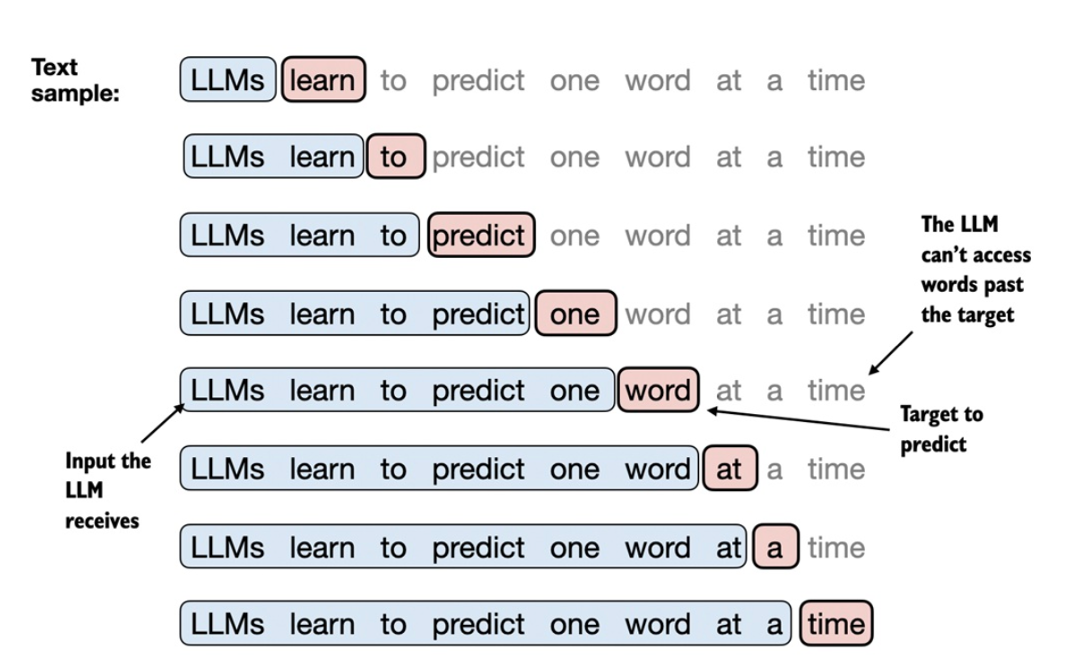

### STEP 1 : Read Corpus  

In [1]:
import pandas as pd 

file1 = open("the-verdict.txt", "r+", encoding="utf-8")

#print("Output of Read function is ")
corpus = file1.read()
#print(text)

# check count of words 
print("word count is -> ", len(corpus))

word count is ->  20479


In [2]:
# check input data 

import re

# Split corpus into tokens 
result = re.split(r'([,.:;?_!"()\']|--|\s)', corpus)

# remove white space 
result = [item for item in result if item.strip()]


# display top 100 tokens

top_100 = []
for index, word in enumerate(result):
    if index > 100:
       break
    top_100.append(word)
print(top_100)


['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in', 'the', 'height', 'of', 'his', 'glory', ',', 'he', 'had', 'dropped', 'his', 'painting', ',', 'married', 'a', 'rich', 'widow', ',', 'and', 'established', 'himself', 'in', 'a', 'villa', 'on', 'the', 'Riviera', '.', '(', 'Though', 'I', 'rather', 'thought', 'it', 'would', 'have', 'been', 'Rome', 'or', 'Florence', '.', ')', '"', 'The', 'height', 'of', 'his', 'glory', '"', '--', 'that', 'was', 'what', 'the', 'women', 'called', 'it', '.', 'I', 'can', 'hear', 'Mrs', '.', 'Gideon', 'Thwing', '--', 'his', 'last', 'Chicago', 'sitter', '--', 'deploring']


### STEP 2 : Tokenize with BPE 

To get started, we will first tokenize the whole The Verdict short story we worked with earlier using the BPE tokenizer introduced in the previous notebook

In [3]:
import importlib
import tiktoken

# initialize tokenizer 
tokenizer = tiktoken.get_encoding("gpt2")

enc_text = tokenizer.encode(corpus)
print(len(enc_text))

# check 1st 50  positions 
print(enc_text[0:50])

# encode 
strings = tokenizer.decode(enc_text)

print(strings[0:50])


# check 1st 100 positions 
print(enc_text[0:100])

# encode 
strings = tokenizer.decode(enc_text)

print(strings[0:100])

5145
[40, 367, 2885, 1464, 1807, 3619, 402, 271, 10899, 2138, 257, 7026, 15632, 438, 2016, 257, 922, 5891, 1576, 438, 568, 340, 373, 645, 1049, 5975, 284, 502, 284, 3285, 326, 11, 287, 262, 6001, 286, 465, 13476, 11, 339, 550, 5710, 465, 12036, 11, 6405, 257, 5527, 27075, 11]
I HAD always thought Jack Gisburn rather a cheap g
[40, 367, 2885, 1464, 1807, 3619, 402, 271, 10899, 2138, 257, 7026, 15632, 438, 2016, 257, 922, 5891, 1576, 438, 568, 340, 373, 645, 1049, 5975, 284, 502, 284, 3285, 326, 11, 287, 262, 6001, 286, 465, 13476, 11, 339, 550, 5710, 465, 12036, 11, 6405, 257, 5527, 27075, 11, 290, 4920, 2241, 287, 257, 4489, 64, 319, 262, 34686, 41976, 13, 357, 10915, 314, 2138, 1807, 340, 561, 423, 587, 10598, 393, 28537, 2014, 198, 198, 1, 464, 6001, 286, 465, 13476, 1, 438, 5562, 373, 644, 262, 1466, 1444, 340, 13, 314, 460, 3285, 9074, 13, 46606, 536]
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no g


In [4]:
## 

### STEP 3:  Set Start Point of Corpus 

Next, we remove the first 50 tokens from the dataset for demonstration purposes as it results in a slightly more interesting text passage in the next steps:

In [5]:
enc_sample = enc_text[50:]

### STEP 4 : Create Input Output Pairs 

**Note** We choose a context size of 4 for this case 

- A consecutive set of 4 tokens are selected as x data 
- A set of 1 token shifted 4 tokens are the y data 

### Illustratative example for creation of X, Y Pairs 

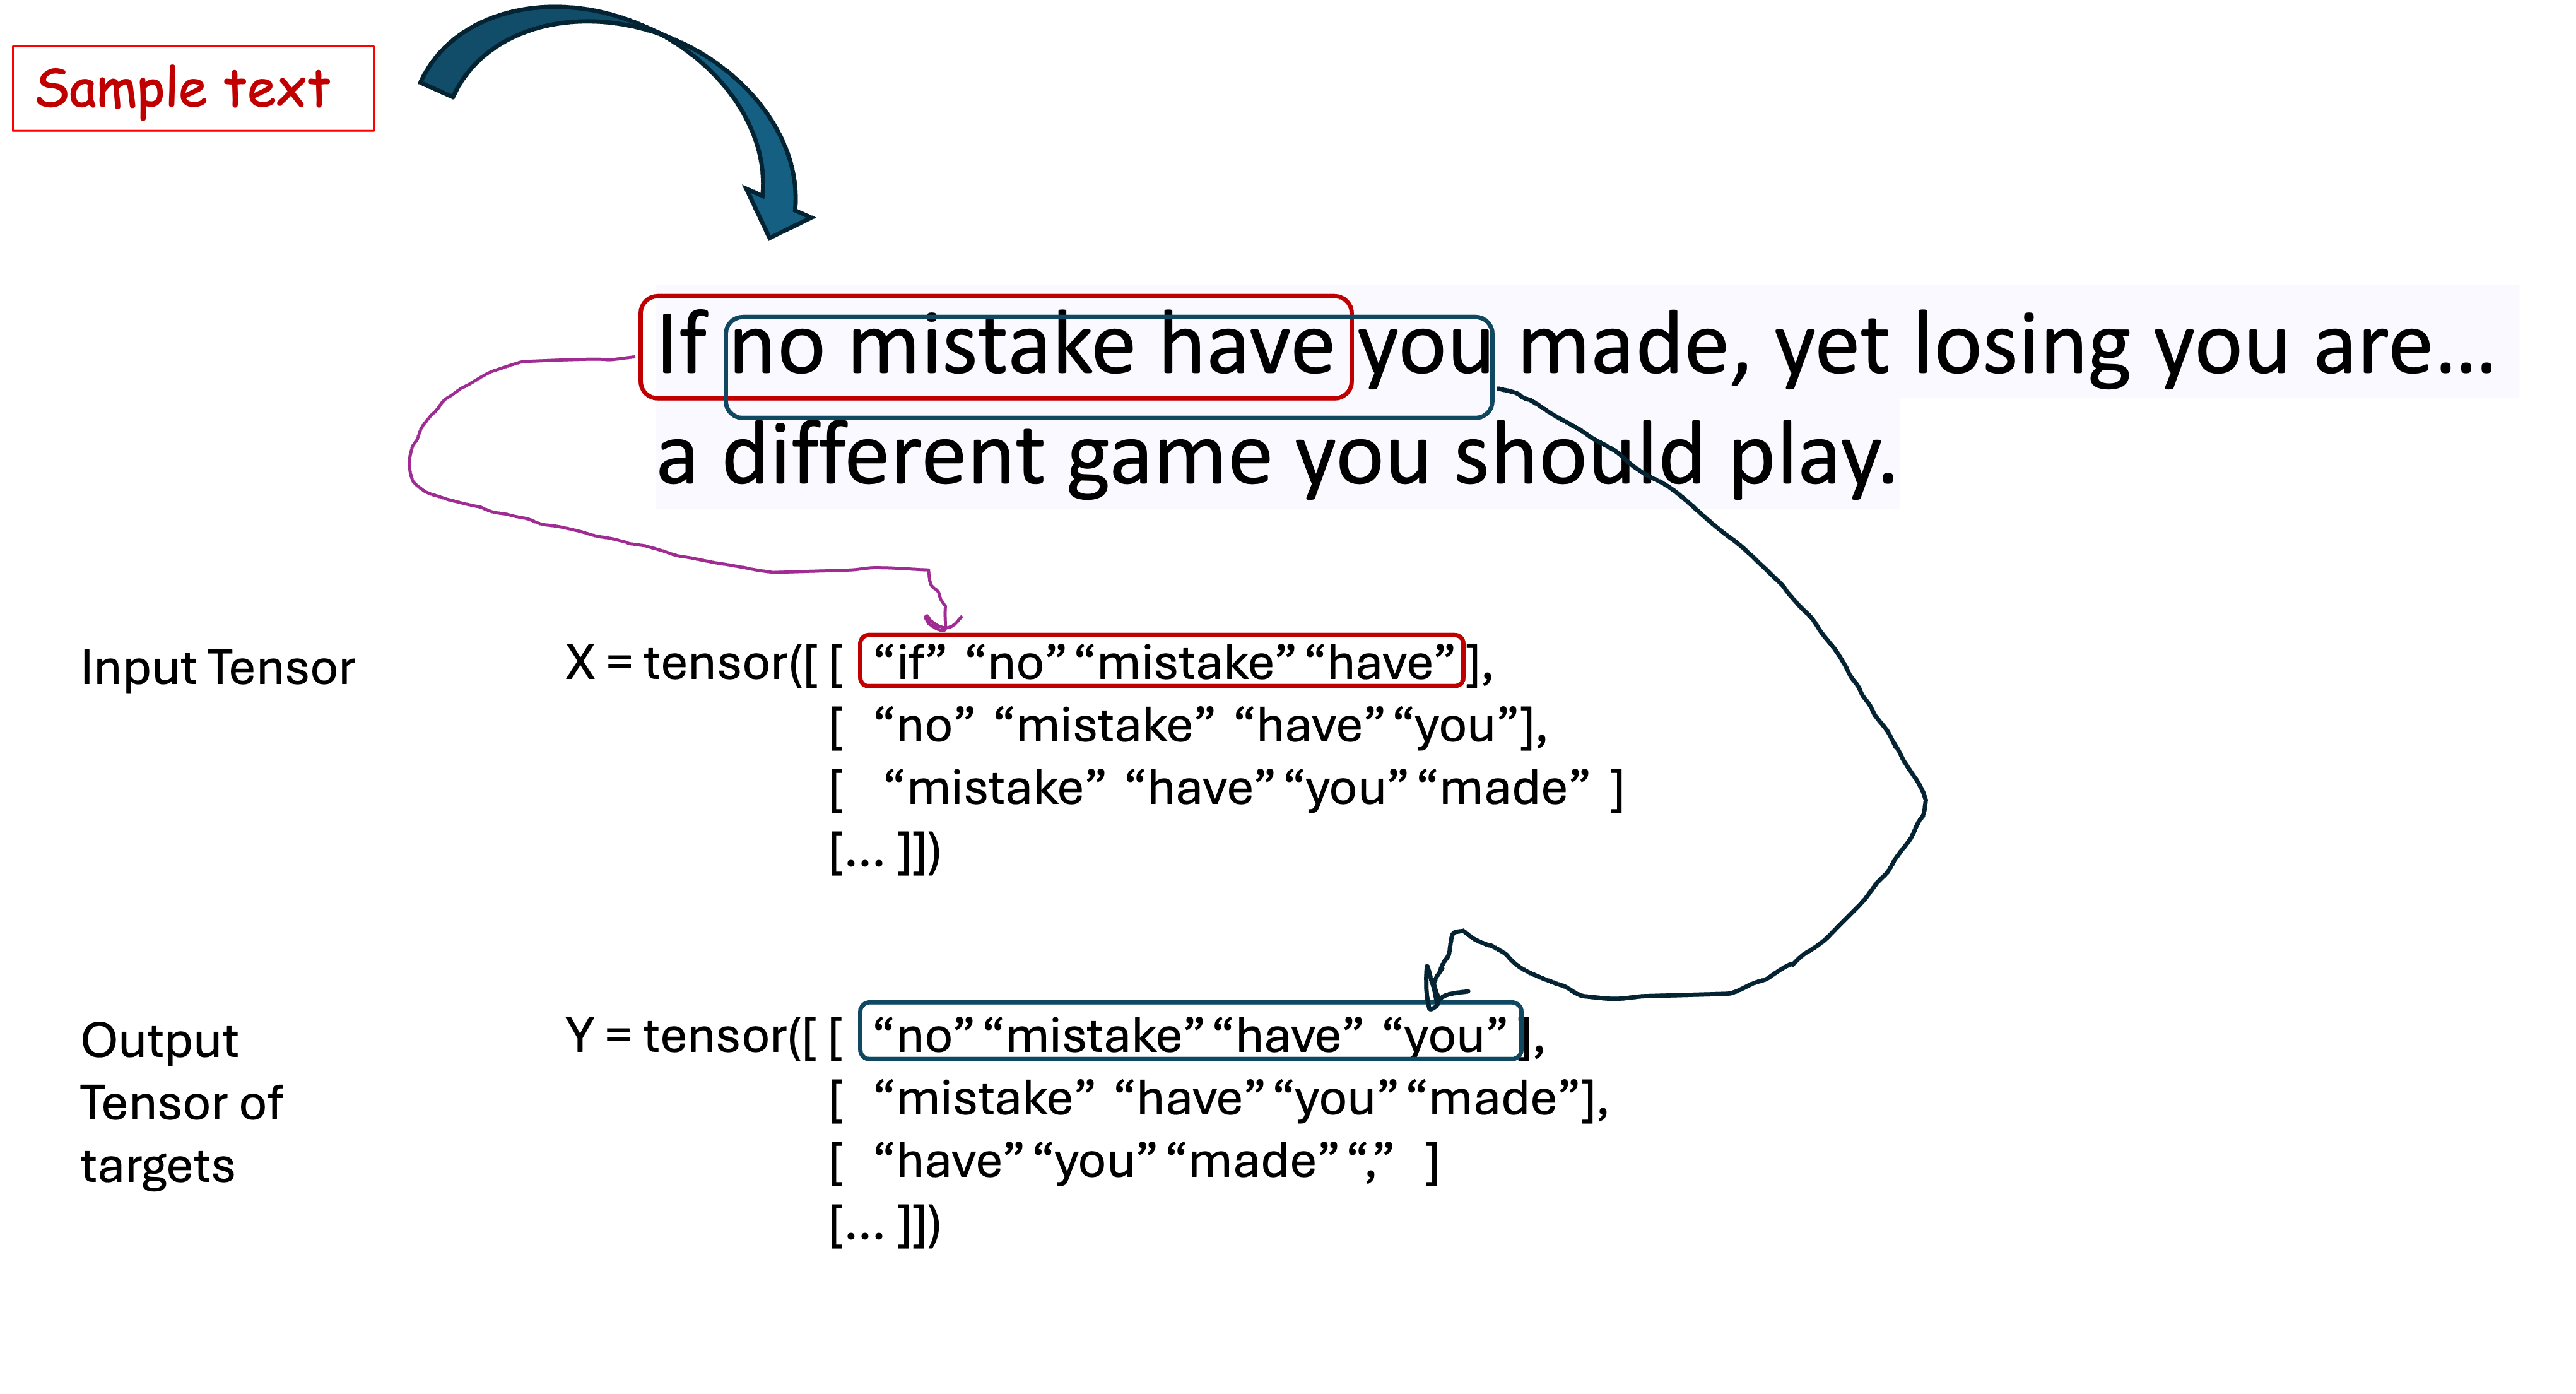

In [6]:
# Set context size 
context_size = 4

In [7]:
# choose x data sample to start from 0 and upto length = context size 
x = enc_sample[:context_size]

# choose y ( target) to be 1 token shifted , and of the same length 
y = enc_sample[1:context_size+1]

# display and check 
print(f"x: {x}")
print(f"y:      {y}")


x: [290, 4920, 2241, 287]
y:      [4920, 2241, 287, 257]


## Illustrative example on next word prediction 

### How would the next word predictions look like 

The below code snippet output demonstrates how every time a next word is predicted its rolled back as inout context till a max context size is reached 

### Simulated - next token prediction 

In [8]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(context, "---->", desired)

[290] ----> 4920
[290, 4920] ----> 2241
[290, 4920, 2241] ----> 287
[290, 4920, 2241, 287] ----> 257


### Simulated Next Token Prediction Translated to String 

In [9]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

 and ---->  established
 and established ---->  himself
 and established himself ---->  in
 and established himself in ---->  a


# Note on  Dataset and Data Loader Class from pytorch 


- PyTorch provides two data primitives: torch.utils.data.DataLoader and torch.utils.data.Dataset that allow you to use pre-loaded datasets as well as your own data. 

- **Dataset** stores the samples and their corresponding labels, and **DataLoader** wraps an iterable around the Dataset to enable easy access to the samples.


REFERENCE
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

### Creating a Custom Dataset Class

A custom Dataset class must implement three functions: init, len, and _getitem, The methods are explained below:

#### init()

The init method is run once when instantiating the Dataset object. It performs the following:


- It instantiates the tokenizer
- The list of tensors for input an doutput token ids are initialized
- The entire corpus is tokenized 
- Based on max length (the number of tokens used for one data row to predict the labels), and the stride (shift), X, data and Y data token ids are generated 
- The input (X)  and output (Y) token id tensors are appended to the list of the input and output token ids 



#### len()

- The len method returns the number of samples in our dataset.

#### getitem()

- The getitem method loads and returns a sample from the dataset at the given index idx.
- Based on the index, it returns the token ids for the x data and that for the corresponding label 


### STEP 5 : Define the Custom Data Set Class 

In [10]:
import torch 
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

/Users/anishroychowdhury/anaconda3/envs/LLM/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Loaders 


The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.

**DataLoader** is an iterable that abstracts this complexity for us in an easy API.


### STEP 6 : Define the Data Loader Function 

#### Arguments 

- txt: The input text data to be processed.
- batch_size (default: 4): Number of samples per batch to load.
- max_length (default: 256): Maximum length of each tokenized sequence.
- stride (default: 128): Stride size for overlapping windows.
- shuffle (default: True): Whether to shuffle the data at every epoch.
- drop_last (default: True): Whether to drop the last incomplete batch if the dataset size is not divisible by the batch size.
- num_workers (default: 0): Number of subprocesses to use for data loading. 0 means data will be loaded in the main process.

### Key Processes 

- Tokenizer Initialization: A GPT-2 compatible tokenizer is initialized.
- Dataset Creation: The input text data is processed using the custom GPTDatasetV1 class, which tokenizes the text and prepares sequences based on the provided max_length and stride.
- DataLoader Creation: A DataLoader is created with the specified batch size, shuffling, and other options.
- Return DataLoader: The DataLoader is returned, ready to be used in model training or evaluation.

In [11]:
from typing import List
from torch.utils.data import DataLoader

def create_dataloader_v1(txt: List[str], batch_size: int = 4, max_length: int = 256, 
                         stride: int = 128, shuffle: bool = True, drop_last: bool = True,
                         num_workers: int = 0) -> DataLoader:
    """
    Creates a PyTorch DataLoader for the given text data.

    Args:
        txt (List[str]): The input text data to be processed.
        batch_size (int, optional): Number of samples per batch to load. Default is 4.
        max_length (int, optional): Maximum length of each tokenized sequence. Default is 256.
        stride (int, optional): Stride size for overlapping windows. Default is 128.
        shuffle (bool, optional): Whether to shuffle the data at every epoch. Default is True.
        drop_last (bool, optional): Whether to drop the last incomplete batch if the dataset size 
                                    is not divisible by the batch size. Default is True.
        num_workers (int, optional): Number of subprocesses to use for data loading. Default is 0.

    Returns:
        DataLoader: A DataLoader object for the given text data.
    """
    
    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader


### Step 7 a : Example usages for 

## Case 1:  Stride = 1 Batch Size = 1 , Context Size = 4 tokens 


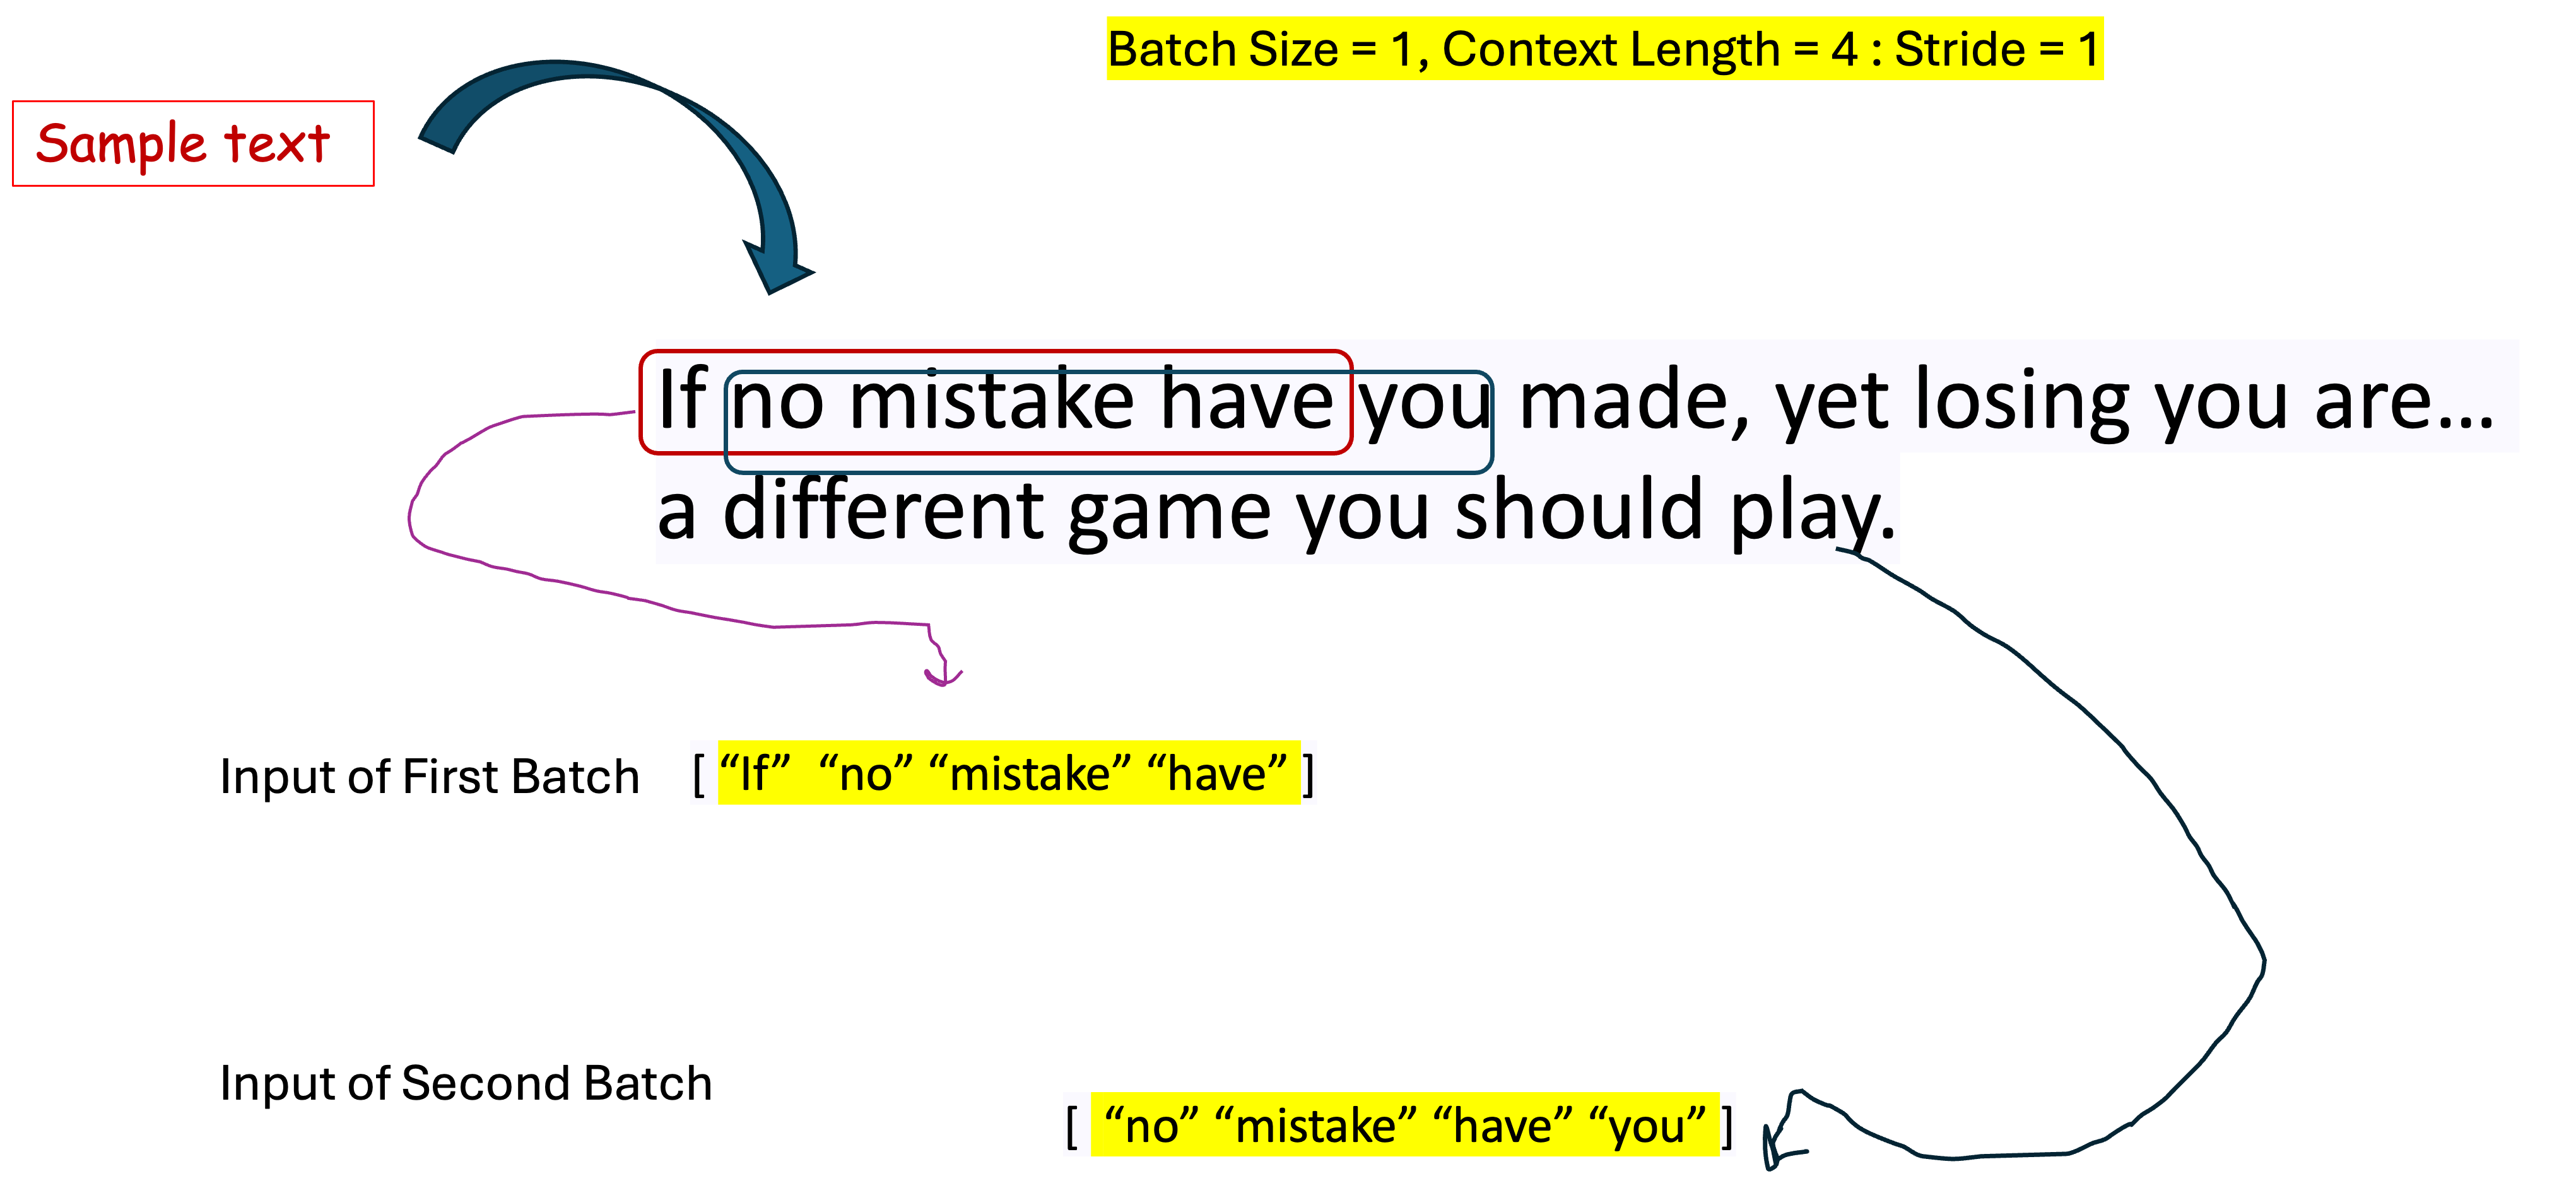

### Note on Batch Size and tensors 

The first_batch variable contains two tensors: the first tensor stores the input token IDs, and the second tensor stores the target token IDs. Since the max_length is set to 4, each of the two tensors contains 4 token IDs. Note that an input size of 4 is relatively small and only chosen for illustration purposes. It is common to train LLMs with input sizes of at least 256.

In [12]:
# check length of corpus again 
print(len(corpus))

20479


In [13]:
# call data loader with 

#     batch size = 1 
#     stride = 1
#     context length = 4 


dataloader = create_dataloader_v1(
    corpus, batch_size=1, max_length=4, stride=1, shuffle=False
)

# Each iter of the data loader fetches a 'batch' size 

# initiate iter 
data_iter = iter(dataloader)

# First batch Tensor



# get the first batch 

first_batch = next(data_iter)
print("first batch tensor  has both input tokens and output tokens ")
print("                                                            ")
print(" display the full tensor from the first batch ")


print(first_batch)
print("                                              ")



print(" ---------------------    first batch Input tokens ------------------")
print(first_batch[0])
print("                                                                     ")

print(" ---------------------    first batch  target tokens ----------------")
print(first_batch[1])
print("                                                                     ")



# get the second batch 
print(" ---------------------    second batch input tokens  ----------------")
second_batch = next(data_iter)
print(second_batch[0])
print("                                                                     ")

print(" ---------------------    second batch  target tokens ----------------")
print(second_batch[1])

                                            

first batch tensor  has both input tokens and output tokens 
                                                            
 display the full tensor from the first batch 
[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]
                                              
 ---------------------    first batch Input tokens ------------------
tensor([[  40,  367, 2885, 1464]])
                                                                     
 ---------------------    first batch  target tokens ----------------
tensor([[ 367, 2885, 1464, 1807]])
                                                                     
 ---------------------    second batch input tokens  ----------------
tensor([[ 367, 2885, 1464, 1807]])
                                                                     
 ---------------------    second batch  target tokens ----------------
tensor([[2885, 1464, 1807, 3619]])


### Step 7b : Example usages for 

## Case 2:  Stride = 2 Batch Size = 1 , Context Size = 4 tokens 


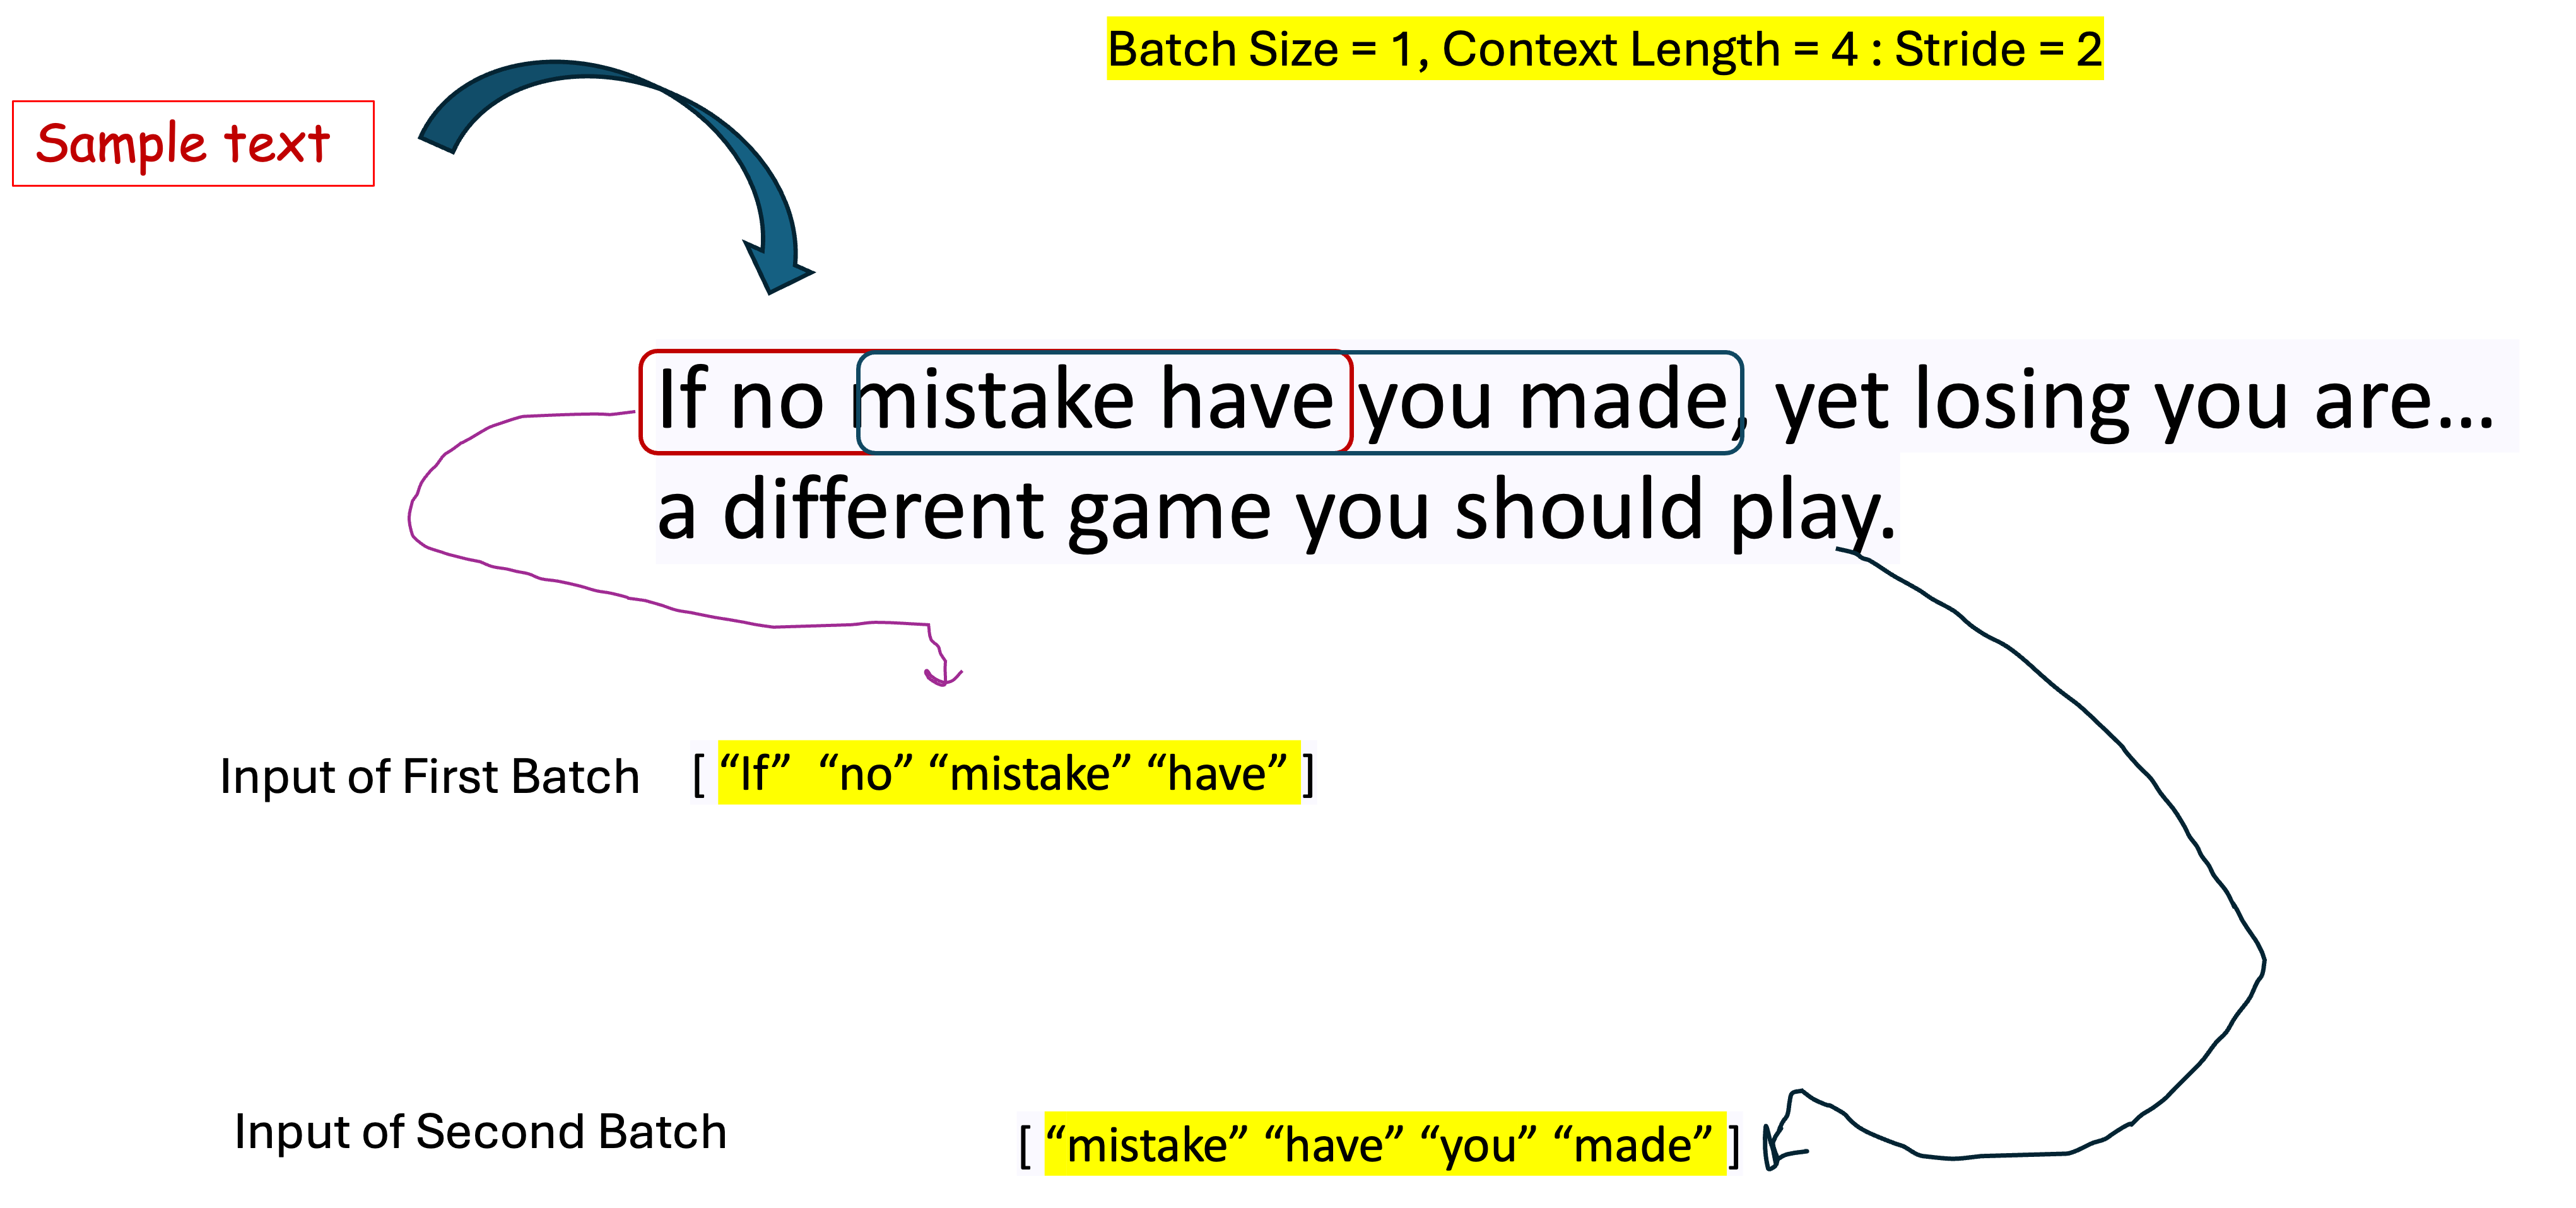

In [14]:
# call data loader with 

#     batch size = 1 
#     stride = 2
#     context length = 4 


dataloader = create_dataloader_v1(
    corpus, batch_size=1, max_length=4, stride=2, shuffle=False
)

# Each iter of the data loader fetches a 'batch' size 

# initiate iter 
data_iter = iter(dataloader)

# get the first batch 

first_batch = next(data_iter)


print("first batch tensor  has both input tokens and output tokens ")
print("                                                            ")
print(" display the full tensor from the first batch ")
print(first_batch)

print("                          ")

print(" ---------------------    first batch Input tokens ------------------")
print(first_batch[0])
print("                                                                     ")

print(" ---------------------    first batch  target tokens ----------------")
print(first_batch[1])
print("                                                                     ")



# get the second batch 
print(" ---------------------    second batch input tokens  ----------------")
second_batch = next(data_iter)
print(second_batch[0])
print("                                                                     ")

print(" ---------------------    second batch  target tokens ----------------")
print(second_batch[1])

       

first batch tensor  has both input tokens and output tokens 
                                                            
 display the full tensor from the first batch 
[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]
                          
 ---------------------    first batch Input tokens ------------------
tensor([[  40,  367, 2885, 1464]])
                                                                     
 ---------------------    first batch  target tokens ----------------
tensor([[ 367, 2885, 1464, 1807]])
                                                                     
 ---------------------    second batch input tokens  ----------------
tensor([[2885, 1464, 1807, 3619]])
                                                                     
 ---------------------    second batch  target tokens ----------------
tensor([[1464, 1807, 3619,  402]])


### Step 7c : Example usages for 

## Case 3:  Stride = 1 Batch Size = 2 , Context Size = 4 tokens 


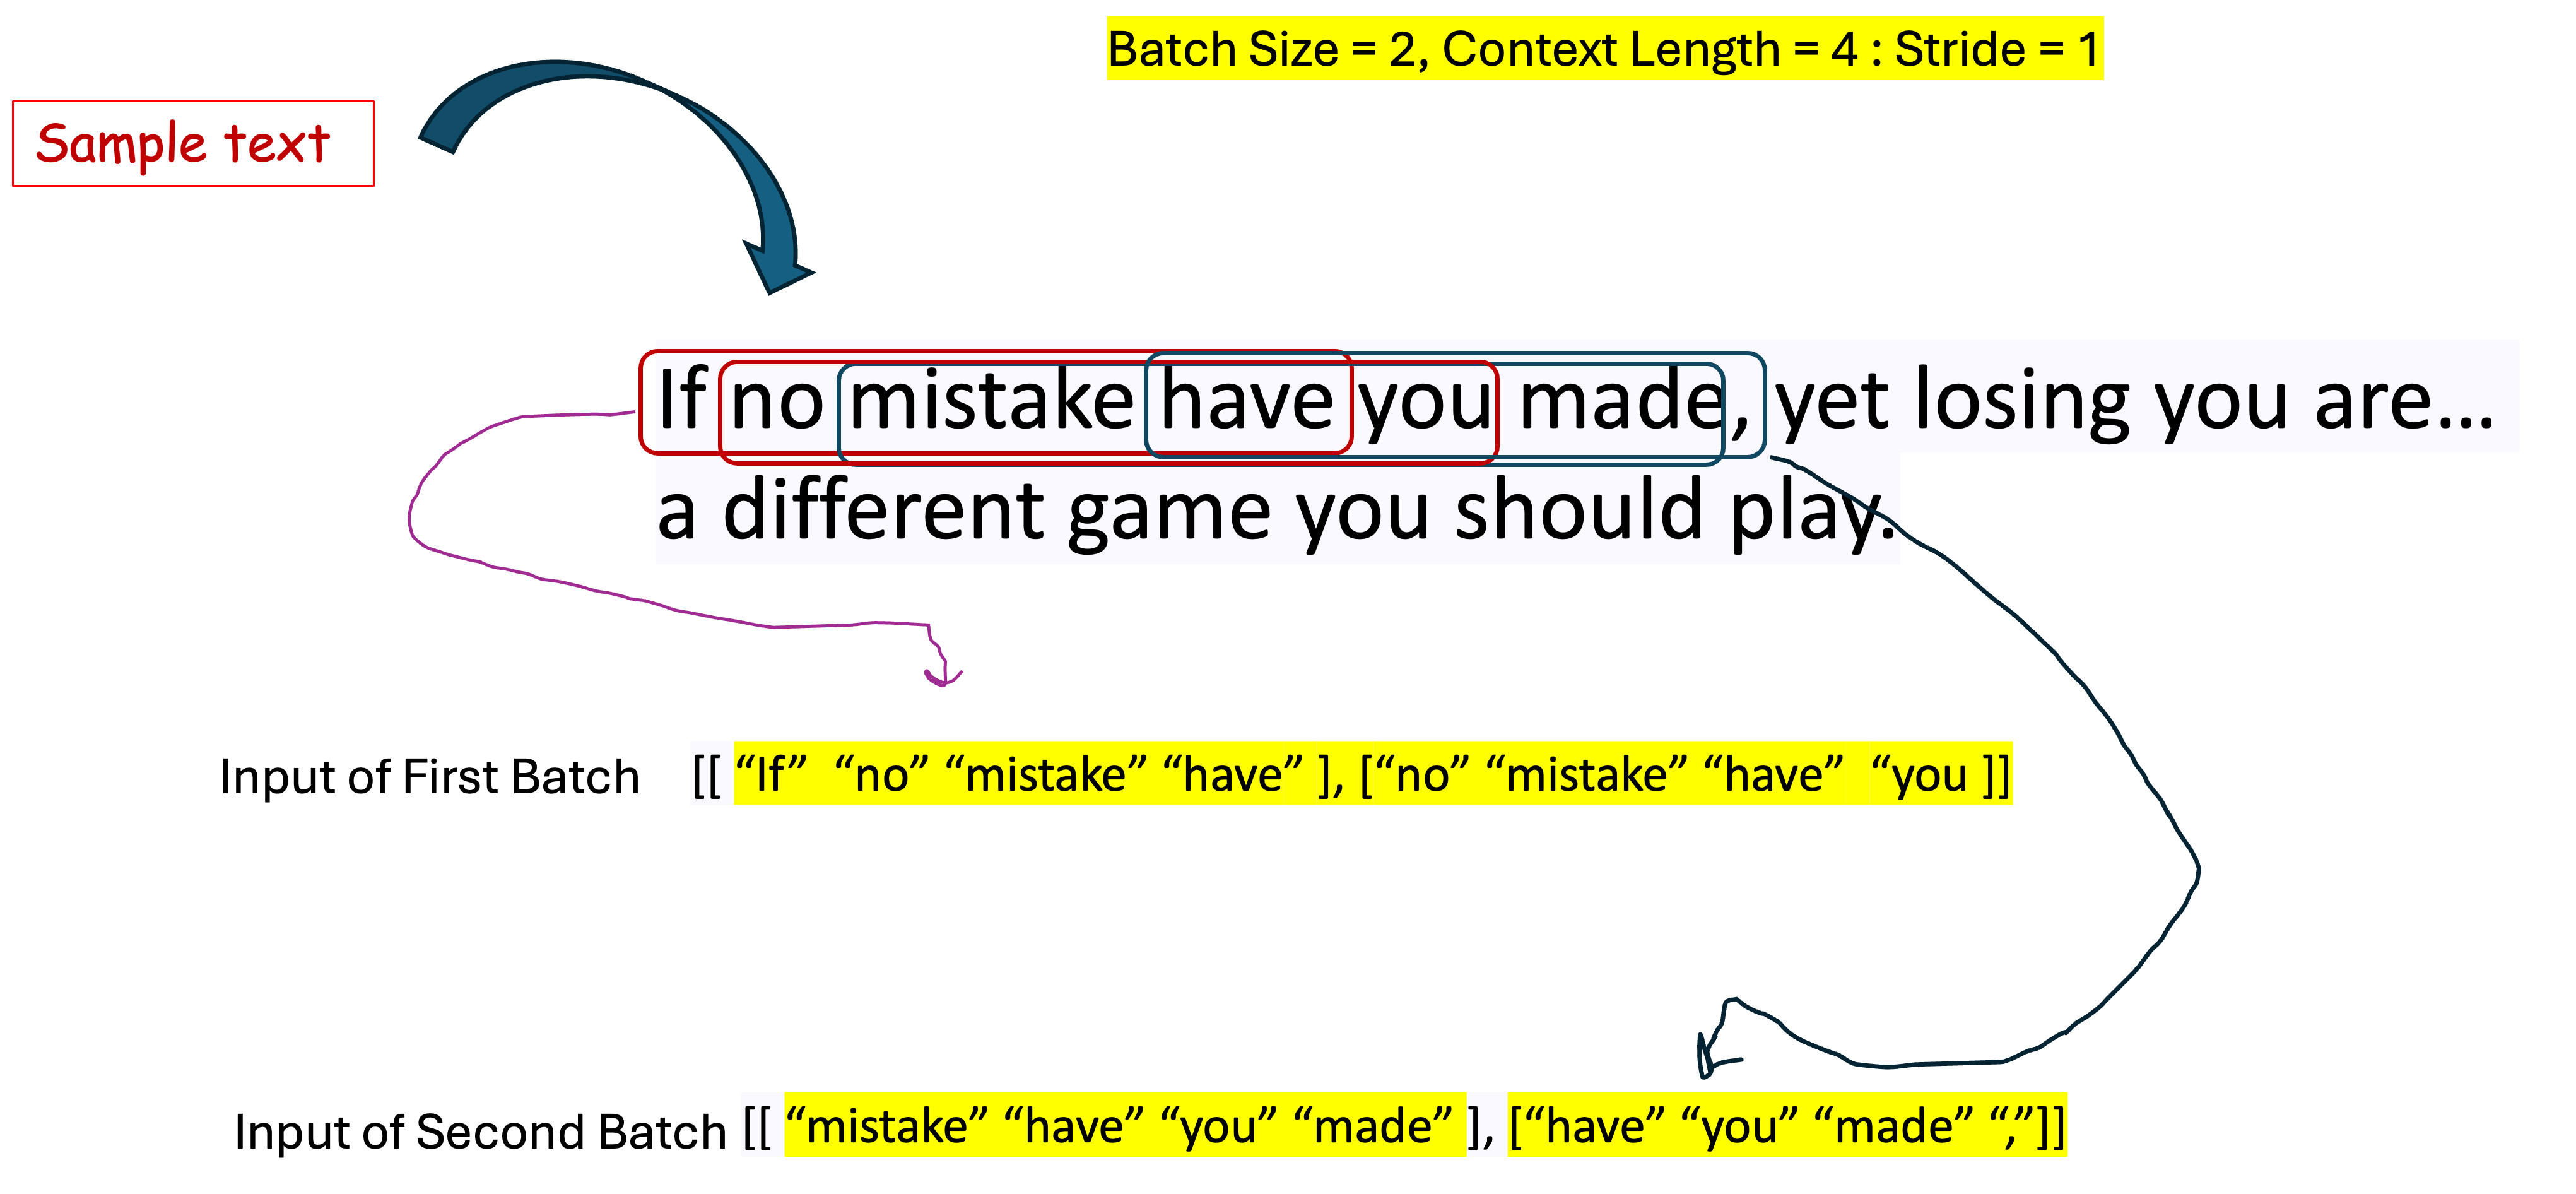

In [15]:
# call data loader with 

#     batch size = 2 
#     stride = 1
#     context length = 4 


dataloader = create_dataloader_v1(
    corpus, batch_size=2, max_length=4, stride=1, shuffle=False
)

# Each iter of the data loader fetches a 'batch' size 

# initiate iter 
data_iter = iter(dataloader)

# get the first batch 

first_batch = next(data_iter)


print("first batch tensor  has both input tokens and output tokens ")
print("                                                            ")
print(" display the full tensor from the first batch ")
print(first_batch)

print("                          ")

print(" ---------------------    first batch Input tokens ------------------")
print(first_batch[0])
print("                                                                     ")

print(" ---------------------    first batch  target tokens ----------------")
print(first_batch[1])
print("                                                                     ")



# get the second batch 
print(" ---------------------    second batch input tokens  ----------------")
second_batch = next(data_iter)
print(second_batch[0])
print("                                                                     ")

print(" ---------------------    second batch  target tokens ----------------")
print(second_batch[1])


first batch tensor  has both input tokens and output tokens 
                                                            
 display the full tensor from the first batch 
[tensor([[  40,  367, 2885, 1464],
        [ 367, 2885, 1464, 1807]]), tensor([[ 367, 2885, 1464, 1807],
        [2885, 1464, 1807, 3619]])]
                          
 ---------------------    first batch Input tokens ------------------
tensor([[  40,  367, 2885, 1464],
        [ 367, 2885, 1464, 1807]])
                                                                     
 ---------------------    first batch  target tokens ----------------
tensor([[ 367, 2885, 1464, 1807],
        [2885, 1464, 1807, 3619]])
                                                                     
 ---------------------    second batch input tokens  ----------------
tensor([[2885, 1464, 1807, 3619],
        [1464, 1807, 3619,  402]])
                                                                     
 ---------------------    second bat

### Step 7d : Example usages for 

## Case 4:  Stride = 2 Batch Size = 2 , Context Size = 4 tokens 

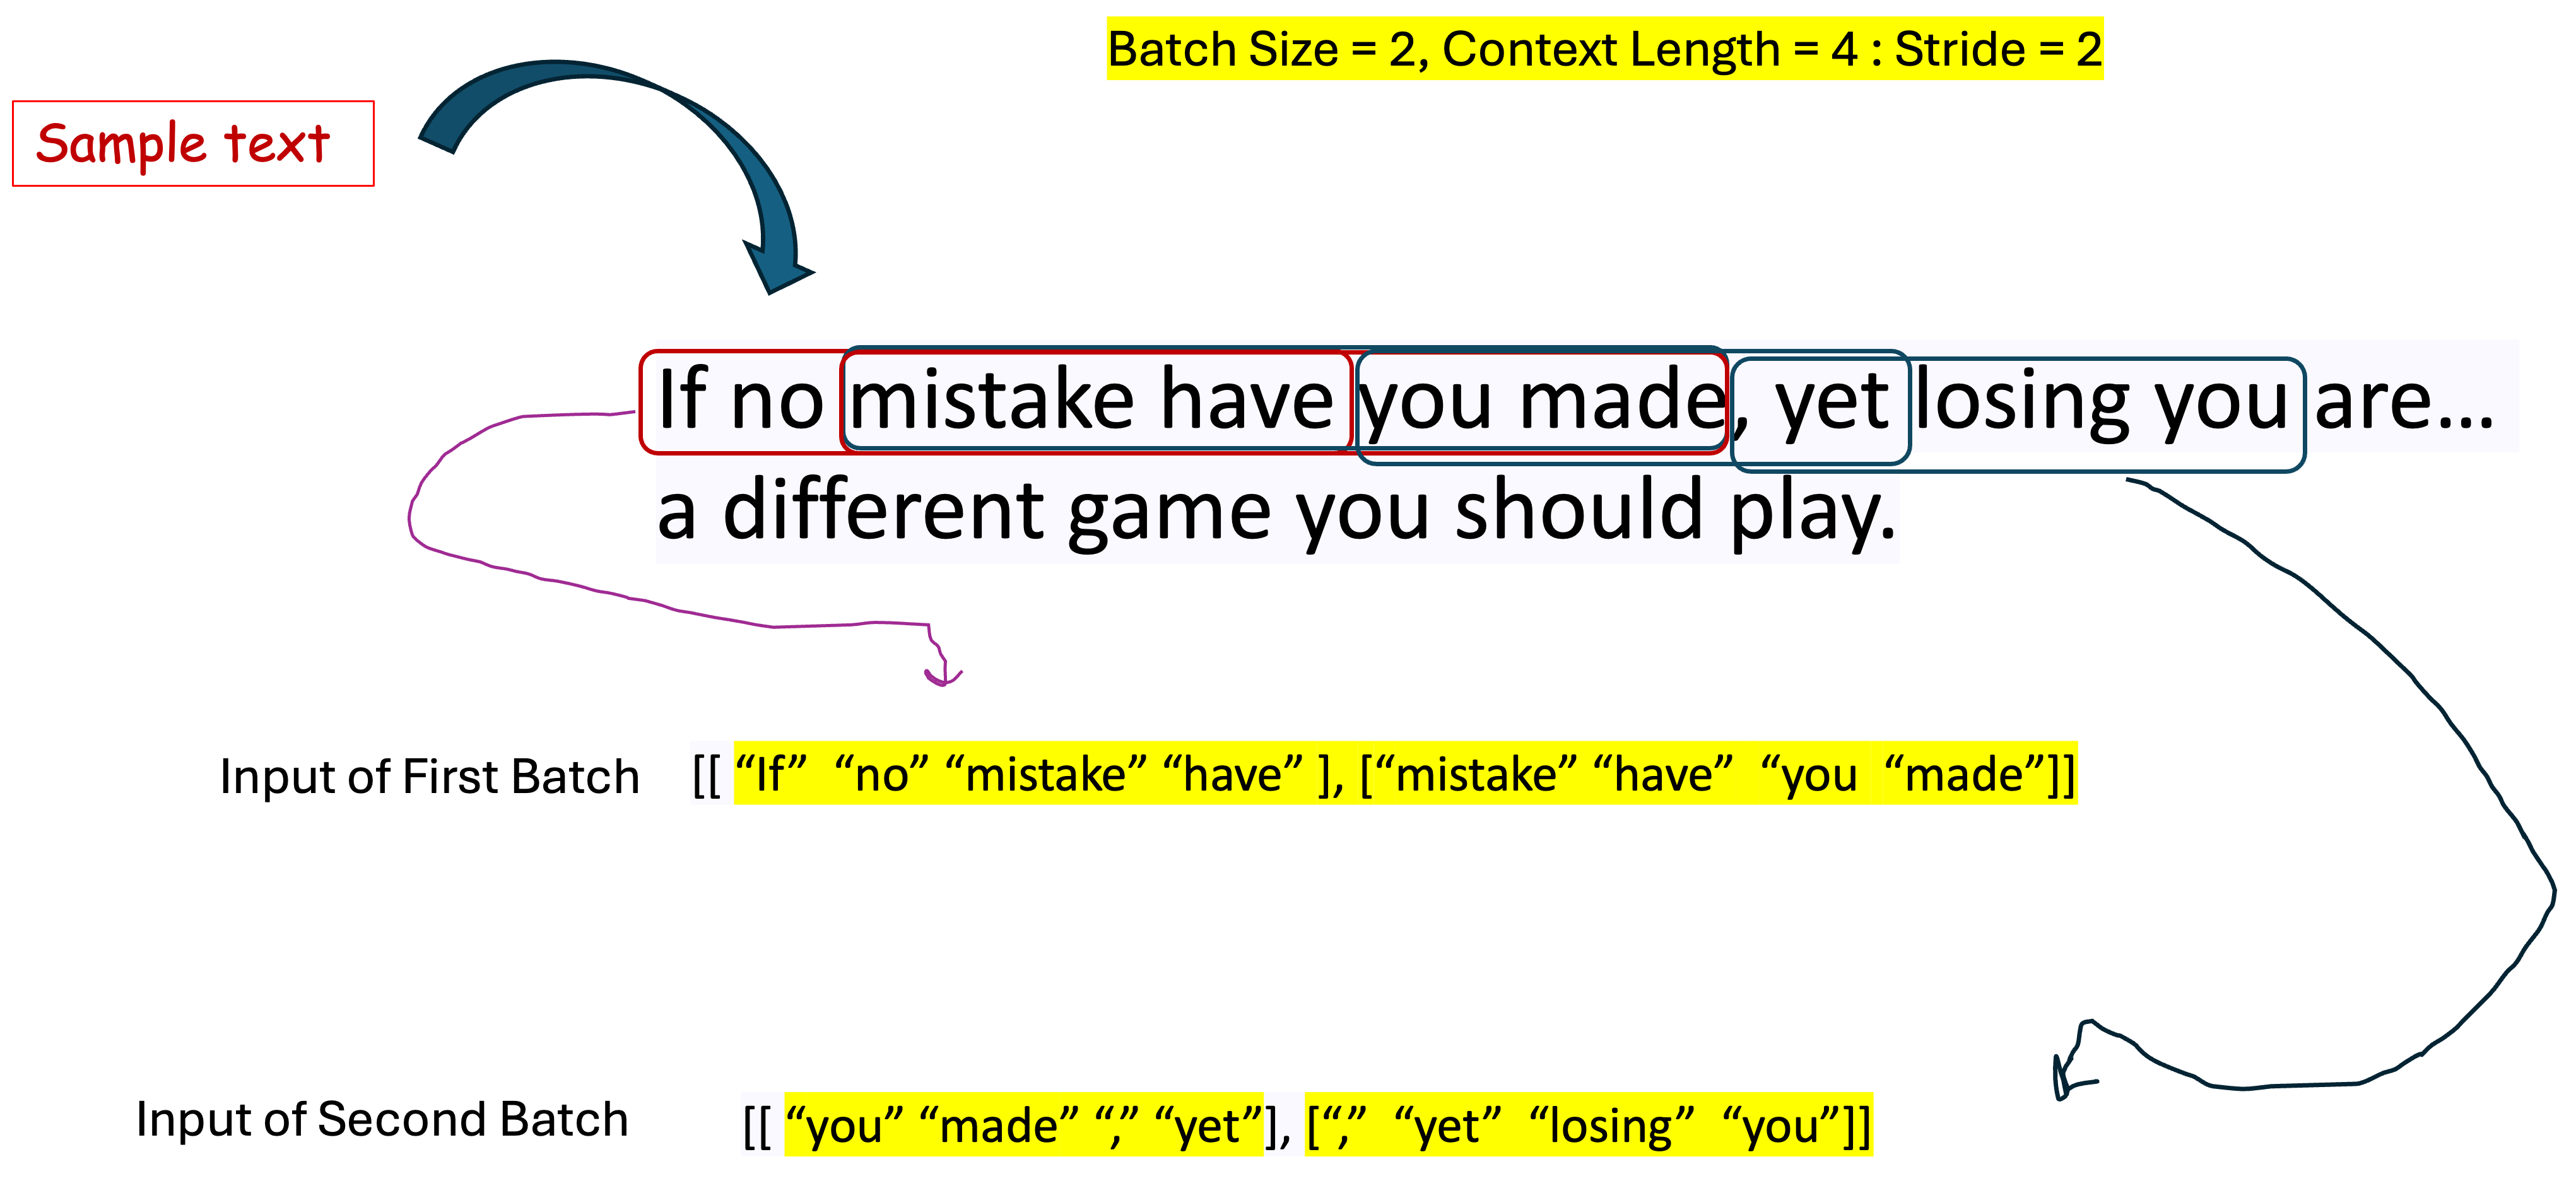

In [16]:

# call data loader with 

#     batch size = 2 
#     stride = 2
#     context length = 4 


dataloader = create_dataloader_v1(
    corpus, batch_size=2, max_length=4, stride=2, shuffle=False
)

# Each iter of the data loader fetches a 'batch' size 

# initiate iter 
data_iter = iter(dataloader)

# get the first batch 

first_batch = next(data_iter)


print("first batch tensor  has both input tokens and output tokens ")
print("                                                            ")
print(" display the full tensor from the first batch ")
print(first_batch)

print("                          ")

print(" ---------------------    first batch Input tokens ------------------")
print(first_batch[0])
print("                                                                     ")

print(" ---------------------    first batch  target tokens ----------------")
print(first_batch[1])
print("                                                                     ")



# get the second batch 
print(" ---------------------    second batch input tokens  ----------------")
second_batch = next(data_iter)
print(second_batch[0])
print("                                                                     ")

print(" ---------------------    second batch  target tokens ----------------")
print(second_batch[1])


first batch tensor  has both input tokens and output tokens 
                                                            
 display the full tensor from the first batch 
[tensor([[  40,  367, 2885, 1464],
        [2885, 1464, 1807, 3619]]), tensor([[ 367, 2885, 1464, 1807],
        [1464, 1807, 3619,  402]])]
                          
 ---------------------    first batch Input tokens ------------------
tensor([[  40,  367, 2885, 1464],
        [2885, 1464, 1807, 3619]])
                                                                     
 ---------------------    first batch  target tokens ----------------
tensor([[ 367, 2885, 1464, 1807],
        [1464, 1807, 3619,  402]])
                                                                     
 ---------------------    second batch input tokens  ----------------
tensor([[ 1807,  3619,   402,   271],
        [  402,   271, 10899,  2138]])
                                                                     
 ---------------------    se

### End of notebook 